In [3]:
from imutils import paths
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import timeit

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.xception import decode_predictions

In [4]:
print("[INFO]: Trying to Read the images")
#  Configure the Image Location
# 이미지 위치 구성하기
imagePaths = list(paths.list_images(r'C:\Users\cvpr\Documents\Bishal\Allergic Rhinitis\Dataset\non_rotate'))

[INFO]: Trying to Read the images


In [5]:
imagePaths = list(paths.list_images("Dataset/non_rotate"))
len(imagePaths)
imagePaths

['Dataset/non_rotate\\dataset0\\0\\n13_1_00002_right.tif',
 'Dataset/non_rotate\\dataset0\\0\\n13_1_00003_left.tif',
 'Dataset/non_rotate\\dataset0\\0\\n13_2_00001_right.tif',
 'Dataset/non_rotate\\dataset0\\0\\n14_1_00001_right.tif',
 'Dataset/non_rotate\\dataset0\\0\\n14_1_00007_left.tif',
 'Dataset/non_rotate\\dataset0\\0\\n15_2_00005_left.tif',
 'Dataset/non_rotate\\dataset0\\0\\n1_1_00001_right.tif',
 'Dataset/non_rotate\\dataset0\\0\\n6_1_00004_right.tif',
 'Dataset/non_rotate\\dataset0\\0\\n6_1_00006_left.tif',
 'Dataset/non_rotate\\dataset0\\1\\14_1_00002_right.tif',
 'Dataset/non_rotate\\dataset0\\1\\7_1_00001_right.tif',
 'Dataset/non_rotate\\dataset0\\1\\7_1_00005_left.tif',
 'Dataset/non_rotate\\dataset0\\2\\2_1_00002_right.tif',
 'Dataset/non_rotate\\dataset0\\2\\2_1_00005_left.tif',
 'Dataset/non_rotate\\dataset0\\2\\3_1_00003_left.tif',
 'Dataset/non_rotate\\dataset0\\2\\4_1_00002_right.tif',
 'Dataset/non_rotate\\dataset0\\2\\6_1_00001_right.tif',
 'Dataset/non_rotate\\

In [6]:
# Initialize data and labels
# 데이터 및 레이블 초기화
data = []
labels = []

In [7]:
# Formatting data and labels
for imagePath in imagePaths:
    # Extract the class label from file name and append to labels
    # 파일 이름에서 클래스 레이블을 추출하고 레이블에 추가함
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
    # Load the image, swap color channels, and resize it to be a fixed 224x224 pixels while ignoring the aspect ratio
    # 이미지를 로드하고, 컬러 채널을 스왑하고, 가로 세로 비율을 무시하고 고정 224x224 픽셀로 크기를 조정함
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    # Append to data
    # 데이터에 추가
    data.append(image)

# Convert the data and labels to NumPy arrays while scaling the pixel intensities to the range [0,1]
# 픽셀 강도를 [0,1] 범위로 조정하면서 데이터와 레이블을 NumPy 배열로 변환
data = np.array(data) / 255.0
labels = np.array(labels)

In [8]:
labels.shape

(90,)

In [9]:
labels

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '2',
       '2', '2', '2', '2', '2', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '2', '2', '2',
       '2', '2', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1',
       '1', '1', '2', '2', '2', '2', '2', '2', '0', '0', '0', '0', '0',
       '0', '0', '0', '1', '1', '1', '2', '2', '2', '2', '2', '2'],
      dtype='<U1')

In [10]:
data.shape

(90, 224, 224, 3)

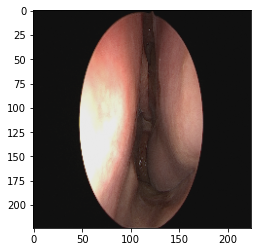

In [11]:
plt.imshow(data[1])

In [12]:
# Perform the one-hot encoding on the labels
# 레이블에 대해 원핫 인코딩 수행
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [13]:
# Initialize the training data augmentation
# 교육 데이터 억멘테이션 초기화
trainAug = ImageDataGenerator(rotation_range=40, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2,
		shear_range=0.15,fill_mode="nearest", horizontal_flip=True)

In [14]:
labels.shape

(90, 3)

In [15]:
# Partition the data into training and testing splits using 80% of the training data and the remaining 20% for testing
# 교육 데이터의 80%, 테스트에 20%를 사용하여 데이터를 교육 및 테스트 분할로 분할
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [16]:
# Load the network, ensuring the Head-FC layer sets are left off
# Head-FC 레이어 세트가 포함되지 않도록 네트워크를 로드한다
baseModel = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

In [17]:
# Construct the head model that will be placed on the top of the base model
# 보디 모델의 맨 위에 배치할 헤드 모델 구성
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4,4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.8)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [18]:
# Place the Head-FC model on top of the Base model - This become the actual model that we will train
# Head-FC 모델을 보디 모델 위에 배치한다. 이것이 우리가 교육할 실제 모델이 될 것이다.
model = Model(inputs=baseModel.input, outputs=headModel)

In [19]:
# Make sure that the basemodel layers will not be trained and only head model will be trained.
# 보디 모델 레이어가 훈련되지 않고 헤드 모델만 훈련되는지 확인한다.
for layer in baseModel.layers:
    layer.trainable = False

In [20]:
trainX.shape

(72, 224, 224, 3)

In [21]:
testX.shape

(18, 224, 224, 3)

In [22]:
# Set the hyper-parameters
# 하이퍼 파라미터 설정
# INIT_LR = 1e-3
INIT_LR = 0.0005
EPOCHS = 200
BS = 8

In [23]:
# Compile the Model
# 모델 컴파일
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [24]:
# Train the Network Model
# 모델 교육
print("[INFO] Model Training")
start = timeit.default_timer()
H = model.fit(
        trainAug.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
        epochs=EPOCHS)

[INFO] Model Training
Epoch 1/200
9/9 [==============================] - 9s 385ms/step - loss: 0.7391 - accuracy: 0.3889 - val_loss: 0.5894 - val_accuracy: 0.5000
Epoch 2/200
9/9 [==============================] - 1s 93ms/step - loss: 0.7492 - accuracy: 0.4444 - val_loss: 0.5319 - val_accuracy: 0.6111
Epoch 3/200
9/9 [==============================] - 1s 93ms/step - loss: 0.7011 - accuracy: 0.3750 - val_loss: 0.5388 - val_accuracy: 0.6667
Epoch 4/200
9/9 [==============================] - 1s 96ms/step - loss: 0.6644 - accuracy: 0.4444 - val_loss: 0.5555 - val_accuracy: 0.7778
Epoch 5/200
9/9 [==============================] - 1s 99ms/step - loss: 0.6936 - accuracy: 0.3611 - val_loss: 0.5766 - val_accuracy: 0.6111
Epoch 6/200
9/9 [==============================] - 1s 92ms/step - loss: 0.6292 - accuracy: 0.4444 - val_loss: 0.5801 - val_accuracy: 0.6111
Epoch 7/200
9/9 [==============================] - 1s 92ms/step - loss: 0.6401 - accuracy: 0.4167 - val_loss: 0.5667 - val_accuracy: 0.50

Epoch 59/200
9/9 [==============================] - 1s 95ms/step - loss: 0.5762 - accuracy: 0.5694 - val_loss: 0.4897 - val_accuracy: 0.7222
Epoch 60/200
9/9 [==============================] - 1s 91ms/step - loss: 0.5511 - accuracy: 0.5278 - val_loss: 0.4825 - val_accuracy: 0.7222
Epoch 61/200
9/9 [==============================] - 1s 99ms/step - loss: 0.4919 - accuracy: 0.7083 - val_loss: 0.4628 - val_accuracy: 0.7222
Epoch 62/200
9/9 [==============================] - 1s 92ms/step - loss: 0.5054 - accuracy: 0.6250 - val_loss: 0.4573 - val_accuracy: 0.7778
Epoch 63/200
9/9 [==============================] - 1s 92ms/step - loss: 0.5043 - accuracy: 0.5556 - val_loss: 0.4564 - val_accuracy: 0.7778
Epoch 64/200
9/9 [==============================] - 1s 99ms/step - loss: 0.5464 - accuracy: 0.5972 - val_loss: 0.4575 - val_accuracy: 0.7778
Epoch 65/200
9/9 [==============================] - 1s 92ms/step - loss: 0.5512 - accuracy: 0.6250 - val_loss: 0.4417 - val_accuracy: 0.7778
Epoch 66/200


Epoch 117/200
9/9 [==============================] - 1s 97ms/step - loss: 0.4725 - accuracy: 0.6389 - val_loss: 0.4031 - val_accuracy: 0.7778
Epoch 118/200
9/9 [==============================] - 1s 90ms/step - loss: 0.4237 - accuracy: 0.7083 - val_loss: 0.4000 - val_accuracy: 0.7222
Epoch 119/200
9/9 [==============================] - 1s 90ms/step - loss: 0.4409 - accuracy: 0.5972 - val_loss: 0.4040 - val_accuracy: 0.7778
Epoch 120/200
9/9 [==============================] - 1s 91ms/step - loss: 0.4696 - accuracy: 0.6667 - val_loss: 0.4139 - val_accuracy: 0.7778
Epoch 121/200
9/9 [==============================] - 1s 94ms/step - loss: 0.4710 - accuracy: 0.6667 - val_loss: 0.4209 - val_accuracy: 0.7778
Epoch 122/200
9/9 [==============================] - 1s 93ms/step - loss: 0.4521 - accuracy: 0.7083 - val_loss: 0.4192 - val_accuracy: 0.7778
Epoch 123/200
9/9 [==============================] - 1s 92ms/step - loss: 0.4742 - accuracy: 0.6250 - val_loss: 0.4082 - val_accuracy: 0.8333
Epoch 

Epoch 175/200
9/9 [==============================] - 1s 91ms/step - loss: 0.4526 - accuracy: 0.7083 - val_loss: 0.4175 - val_accuracy: 0.8333
Epoch 176/200
9/9 [==============================] - 1s 94ms/step - loss: 0.3789 - accuracy: 0.7917 - val_loss: 0.4075 - val_accuracy: 0.8333
Epoch 177/200
9/9 [==============================] - 1s 92ms/step - loss: 0.4239 - accuracy: 0.6667 - val_loss: 0.3981 - val_accuracy: 0.7778
Epoch 178/200
9/9 [==============================] - 1s 91ms/step - loss: 0.4239 - accuracy: 0.6806 - val_loss: 0.3922 - val_accuracy: 0.8333
Epoch 179/200
9/9 [==============================] - 1s 94ms/step - loss: 0.4311 - accuracy: 0.6250 - val_loss: 0.3853 - val_accuracy: 0.8333
Epoch 180/200
9/9 [==============================] - 1s 96ms/step - loss: 0.3889 - accuracy: 0.7083 - val_loss: 0.3926 - val_accuracy: 0.7778
Epoch 181/200
9/9 [==============================] - 1s 90ms/step - loss: 0.4381 - accuracy: 0.7222 - val_loss: 0.3957 - val_accuracy: 0.7778
Epoch 

In [25]:
stop = timeit.default_timer()
print('Total Training Time: ', stop - start) 

Total Training Time:  187.72934759999998


In [26]:
testX.shape

(18, 224, 224, 3)

In [31]:
# Make predictions on the testing set
# 테스트 세트에서 예측한다
print("Making Predictions on the Test Set")
predIdxs = model.predict(testX, batch_size=BS)
preds = predIdxs
predIdxs = np.argmax(predIdxs, axis=1)
print("Classification Report")
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

Making Predictions on the Test Set
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.00      0.00      0.00         3
           2       0.86      1.00      0.92         6

    accuracy                           0.78        18
   macro avg       0.53      0.63      0.57        18
weighted avg       0.65      0.78      0.71        18



C:\Users\cvpr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cvpr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cvpr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
preds

array([[6.7665344e-01, 6.1392397e-02, 2.6195410e-01],
       [8.8178046e-02, 7.8781046e-02, 8.3304095e-01],
       [4.0834792e-02, 3.4841102e-02, 9.2432410e-01],
       [1.5690053e-01, 4.3971993e-02, 7.9912752e-01],
       [5.8102101e-01, 3.5178420e-01, 6.7194775e-02],
       [9.6635991e-01, 1.5935674e-02, 1.7704370e-02],
       [1.7239696e-01, 1.0772405e-01, 7.1987897e-01],
       [9.9676871e-01, 1.4535846e-03, 1.7777567e-03],
       [9.9446243e-01, 1.2759479e-03, 4.2615798e-03],
       [9.9262446e-01, 9.2285319e-04, 6.4526931e-03],
       [6.6700882e-01, 2.7433202e-01, 5.8659144e-02],
       [8.5803354e-01, 2.6607346e-02, 1.1535911e-01],
       [9.9382621e-01, 1.4951765e-03, 4.6786005e-03],
       [4.7754747e-01, 2.8895877e-02, 4.9355668e-01],
       [1.5137527e-02, 1.9333386e-01, 7.9152864e-01],
       [9.9726796e-01, 4.3431894e-04, 2.2977979e-03],
       [6.1182749e-01, 6.2397148e-02, 3.2577536e-01],
       [1.3286086e-02, 2.4324822e-01, 7.4346566e-01]], dtype=float32)

In [33]:
len(predIdxs)

18

In [34]:
# Compute Confusion Matrix and derrive raw, accuracy, sensitivity, specificity from it
# 혼란 매트릭스
cm= confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0,0] + cm[1,1] + cm[2,2]) / total

sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
# 혼란 매트릭스 보기
print("Confusion Matrix and its Derrivatives")
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

Confusion Matrix and its Derrivatives
[[8 0 1]
 [3 0 0]
 [0 0 6]]
acc: 0.7778
sensitivity: 1.0000
specificity: 0.0000


In [35]:
H.history["accuracy"]

[0.3888888955116272,
 0.4444444477558136,
 0.375,
 0.4444444477558136,
 0.3611111044883728,
 0.4444444477558136,
 0.4166666567325592,
 0.4305555522441864,
 0.4722222089767456,
 0.5138888955116272,
 0.5138888955116272,
 0.5,
 0.4583333432674408,
 0.5833333134651184,
 0.4861111044883728,
 0.5416666865348816,
 0.5138888955116272,
 0.5694444179534912,
 0.625,
 0.5555555820465088,
 0.5555555820465088,
 0.4444444477558136,
 0.5972222089767456,
 0.5416666865348816,
 0.5972222089767456,
 0.5416666865348816,
 0.5138888955116272,
 0.6111111044883728,
 0.6111111044883728,
 0.6805555820465088,
 0.6111111044883728,
 0.5972222089767456,
 0.4861111044883728,
 0.5555555820465088,
 0.6388888955116272,
 0.5138888955116272,
 0.5,
 0.5277777910232544,
 0.5972222089767456,
 0.5833333134651184,
 0.5833333134651184,
 0.5277777910232544,
 0.5833333134651184,
 0.5277777910232544,
 0.625,
 0.5416666865348816,
 0.6111111044883728,
 0.5833333134651184,
 0.6111111044883728,
 0.5555555820465088,
 0.5972222089767456

Final Plot Generated.


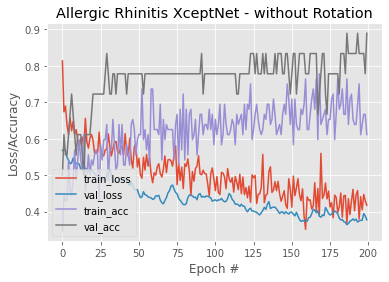

In [30]:
# plot the training loss and accuracy
# 플롯 그래프
print("Final Plot Generated.")
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Allergic Rhinitis XceptNet - without Rotation")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("[iter-3] [XCEPTN] plot-rotate-5e3")

model.output_shape # model summary representation
model.summary() # model configuration
model.get_config() # list all weight tensors in the model

In [31]:
model.output_shape

(None, 3)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [33]:
preds

array([[0.7516289 , 0.06192304, 0.1864481 ],
       [0.10407793, 0.09171676, 0.80420536],
       [0.07064211, 0.06510772, 0.86425024],
       [0.14283405, 0.07766575, 0.77950025],
       [0.52259326, 0.27501273, 0.20239404],
       [0.95238346, 0.02052167, 0.02709491],
       [0.28096455, 0.17636415, 0.5426713 ],
       [0.98297113, 0.00585327, 0.01117557],
       [0.9924345 , 0.00121826, 0.0063473 ],
       [0.98637646, 0.00250489, 0.01111859],
       [0.38327476, 0.392655  , 0.2240703 ],
       [0.8550931 , 0.02963339, 0.11527348],
       [0.99280715, 0.00269316, 0.00449968],
       [0.63500684, 0.03348587, 0.3315073 ],
       [0.01699335, 0.08483937, 0.8981673 ],
       [0.99040926, 0.00364083, 0.00594995],
       [0.63765   , 0.14851236, 0.21383762],
       [0.00843361, 0.15157929, 0.83998704]], dtype=float32)

In [34]:
model.save("ARhinitisModel", save_format="h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

C:\Users\cvpr\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


print("[INFO] saving Allergic Rhinitis detector model...")
model.save("ARhinitisModel", save_format="h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

decoded = imagenet_utils.decode_predictions(preds)

gradCAM


In [36]:
from gradCam import GradCAM
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [37]:
d_path = r'C:\Users\cvpr\Documents\Bishal\Allergic Rhinitis\Dataset\non_rotate\dataset0\1\7_1_00005_left.tif'
orig = cv2.imread(d_path)
resized = cv2.resize(orig, (224, 224))
image = load_img(d_path, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

cam = GradCAM(model, predIdxs)

In [38]:
preds = model.predict(image)
i = np.argmax(preds[0])
print(image.shape)

(1, 224, 224, 3)


In [39]:
cam = GradCAM(model, i)

dense_1 :  (None, 3)
dropout :  (None, 64)
dense :  (None, 64)
flatten :  (None, 2048)
average_pooling2d :  (None, 1, 1, 2048)
0
block14_sepconv2_act :  (None, 7, 7, 2048)


In [40]:
heatmap = cam.compute_heatmap(image)

In [41]:
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))

In [42]:
cv2.imshow("Output", heatmap)
cv2.imwrite("heatr", heatmap)

error: OpenCV(4.5.1) ..\modules\imgcodecs\src\loadsave.cpp:682: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'


In [ ]:

(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

In [ ]:
for i in testX:
    image = np.expand_dims(i, axis=0)
    image = imagenet_utils.preprocess_input(i)
    heatmap = cam.compute_heatmap(image)